In [1]:
# Importing the libraries
library(ggplot2)
library(dplyr)
library(caTools)
library(Amelia)
library(pander)
library(reticulate)

# Import pandas
pandas <- import("pandas")

# Set working directory
#setwd("ML - Logistic Regression with R/ML - Logistic Regression Project")

# Read the CSV file
adult <- read.csv("adult_sal.csv")

# Verify the data frame
adult <- select(adult, -X)
str(adult)
print("Complete")

Warning message:
"package 'ggplot2' was built under R version 4.4.1"
Warning message:
"package 'dplyr' was built under R version 4.4.1"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'caTools' was built under R version 4.4.1"
Warning message:
"package 'Amelia' was built under R version 4.4.1"
Loading required package: Rcpp

Warning message:
"package 'Rcpp' was built under R version 4.4.1"
## 
## Amelia II: Multiple Imputation
## (Version 1.8.2, built: 2024-04-10)
## Copyright (C) 2005-2024 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 

Warning message:
"package 'pander' was built under R version 4.4.1"
Warning message:
"package 'reticulate' was built under R version 4.4.1"


'data.frame':	32561 obs. of  15 variables:
 $ age          : int  39 50 38 53 28 37 49 52 31 42 ...
 $ type_employer: chr  "State-gov" "Self-emp-not-inc" "Private" "Private" ...
 $ fnlwgt       : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education    : chr  "Bachelors" "Bachelors" "HS-grad" "11th" ...
 $ education_num: int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital      : chr  "Never-married" "Married-civ-spouse" "Divorced" "Married-civ-spouse" ...
 $ occupation   : chr  "Adm-clerical" "Exec-managerial" "Handlers-cleaners" "Handlers-cleaners" ...
 $ relationship : chr  "Not-in-family" "Husband" "Not-in-family" "Husband" ...
 $ race         : chr  "White" "White" "White" "Black" ...
 $ sex          : chr  "Male" "Male" "Male" "Male" ...
 $ capital_gain : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital_loss : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hr_per_week  : int  40 13 40 40 40 40 16 45 50 40 ...
 $ country      : chr  "United-States" "United-States" "U

In [2]:
# Check for missing values
table(adult$type_employer)
summary(adult)


               ?      Federal-gov        Local-gov     Never-worked 
            1836              960             2093                7 
         Private     Self-emp-inc Self-emp-not-inc        State-gov 
           22696             1116             2541             1298 
     Without-pay 
              14 

      age        type_employer          fnlwgt         education        
 Min.   :17.00   Length:32561       Min.   :  12285   Length:32561      
 1st Qu.:28.00   Class :character   1st Qu.: 117827   Class :character  
 Median :37.00   Mode  :character   Median : 178356   Mode  :character  
 Mean   :38.58                      Mean   : 189778                     
 3rd Qu.:48.00                      3rd Qu.: 237051                     
 Max.   :90.00                      Max.   :1484705                     
 education_num     marital           occupation        relationship      
 Min.   : 1.00   Length:32561       Length:32561       Length:32561      
 1st Qu.: 9.00   Class :character   Class :character   Class :character  
 Median :10.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :10.08                                                           
 3rd Qu.:12.00                                                           
 Max.   :16.00                               

In [3]:
# Check for missing values
table(adult$type_employer)



               ?      Federal-gov        Local-gov     Never-worked 
            1836              960             2093                7 
         Private     Self-emp-inc Self-emp-not-inc        State-gov 
           22696             1116             2541             1298 
     Without-pay 
              14 

In [4]:
# 1836 Null Values, never worked and without pay.
# Replace with unemployed
unemp <- function(job) {
    job <- as.character(job)
    if (job == "Never-worked" | job == "Without-pay") {
        return("Unemployed")
    } else {
        return(job)
    }
}
adult$type_employer <- sapply(adult$type_employer, unemp)
table(adult$type_employer)


               ?      Federal-gov        Local-gov          Private 
            1836              960             2093            22696 
    Self-emp-inc Self-emp-not-inc        State-gov       Unemployed 
            1116             2541             1298               21 

In [5]:
# Group Local-gov, State-gov, Self-emp-inc, Self-emp-not-inc
group_emp <- function(job) {
    if (job == "Local-gov" | job == "State-gov") {
        return("SL-gov")
    } else if (job == "Self-emp-inc" | job == "Self-emp-not-inc") {
        return("self-emp")
    } else {
        return(job)
    }
}
adult$type_employer <- sapply(adult$type_employer, group_emp)
table(adult$type_employer)


          ? Federal-gov     Private    self-emp      SL-gov  Unemployed 
       1836         960       22696        3657        3391          21 

In [6]:
# Grouping the marital status
table(adult$marital)
group_marital <- function(mar) {
    mar <- as.character(mar)

    # Not-Married
    if (mar == "Separated" | mar == "Divorced" | mar == "Widowed") {
        return("Not-Married")

        # Never-Married
    } else if (mar == "Never-married") {
        return(mar)

        # Married
    } else {
        return("Married")
    }
}
adult$marital <- sapply(adult$marital, group_marital)
table(adult$marital)


             Divorced     Married-AF-spouse    Married-civ-spouse 
                 4443                    23                 14976 
Married-spouse-absent         Never-married             Separated 
                  418                 10683                  1025 
              Widowed 
                  993 


      Married Never-married   Not-Married 
        15417         10683          6461 

In [7]:
# Screen country
table(adult$country)

# Grouping countrys
levels(adult$country)

Asia <- c(
    "China", "Hong", "India", "Iran", "Cambodia", "Japan", "Laos",
    "Philippines", "Vietnam", "Taiwan", "Thailand"
)

North.America <- c("Canada", "United-States", "Puerto-Rico")

Europe <- c(
    "England", "France", "Germany", "Greece", "Holand-Netherlands", "Hungary",
    "Ireland", "Italy", "Poland", "Portugal", "Scotland", "Yugoslavia"
)

Latin.and.South.America <- c(
    "Columbia", "Cuba", "Dominican-Republic", "Ecuador",
    "El-Salvador", "Guatemala", "Haiti", "Honduras",
    "Mexico", "Nicaragua", "Outlying-US(Guam-USVI-etc)", "Peru",
    "Jamaica", "Trinadad&Tobago"
)
Other <- c("South")

group_country <- function(ctry) {
    if (ctry %in% Asia) {
        return("Asia")
    } else if (ctry %in% North.America) {
        return("North.America")
    } else if (ctry %in% Europe) {
        return("Europe")
    } else if (ctry %in% Latin.and.South.America) {
        return("Latin.and.South.America")
    } else {
        return("Other")
    }
}

# Apply the function
adult$country <- sapply(adult$country, group_country)

# screen results
table(adult$country)


                         ?                   Cambodia 
                       583                         19 
                    Canada                      China 
                       121                         75 
                  Columbia                       Cuba 
                        59                         95 
        Dominican-Republic                    Ecuador 
                        70                         28 
               El-Salvador                    England 
                       106                         90 
                    France                    Germany 
                        29                        137 
                    Greece                  Guatemala 
                        29                         64 
                     Haiti         Holand-Netherlands 
                        44                          1 
                  Honduras                       Hong 
                        13                         20 
         

NULL


                   Asia                  Europe Latin.and.South.America 
                    671                     521                    1301 
          North.America                   Other 
                  29405                     663 

In [8]:
# Factorise the dataset
adult$type_employer <- sapply(adult$type_employer, factor)
adult$country <- sapply(adult$country, factor)
adult$marital <- sapply(adult$marital, factor)
adult$income <- sapply(adult$income, factor)
adult$education <- sapply(adult$education, factor)
adult$occupation <- sapply(adult$occupation, factor)
adult$relationship <- sapply(adult$relationship, factor)
adult$race <- sapply(adult$race, factor)
adult$sex <- sapply(adult$sex, factor)
str(adult)
summary(adult)

'data.frame':	32561 obs. of  15 variables:
 $ age          : int  39 50 38 53 28 37 49 52 31 42 ...
 $ type_employer: Factor w/ 6 levels "SL-gov","self-emp",..: 1 2 3 3 3 3 3 2 3 3 ...
 $ fnlwgt       : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education    : Factor w/ 16 levels "Bachelors","HS-grad",..: 1 1 2 3 1 4 5 2 4 1 ...
 $ education_num: int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital      : Factor w/ 3 levels "Never-married",..: 1 2 3 2 2 2 2 2 1 2 ...
 $ occupation   : Factor w/ 15 levels "Adm-clerical",..: 1 2 3 3 4 2 5 2 4 2 ...
 $ relationship : Factor w/ 6 levels "Not-in-family",..: 1 2 1 2 3 3 1 2 1 2 ...
 $ race         : Factor w/ 5 levels "White","Black",..: 1 1 1 2 2 1 2 1 1 1 ...
 $ sex          : Factor w/ 2 levels "Male","Female": 1 1 1 1 2 2 2 1 2 1 ...
 $ capital_gain : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital_loss : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hr_per_week  : int  40 13 40 40 40 40 16 45 50 40 ...
 $ country      :

      age            type_employer       fnlwgt               education    
 Min.   :17.00   SL-gov     : 3391   Min.   :  12285   HS-grad     :10501  
 1st Qu.:28.00   self-emp   : 3657   1st Qu.: 117827   Some-college: 7291  
 Median :37.00   Private    :22696   Median : 178356   Bachelors   : 5355  
 Mean   :38.58   Federal-gov:  960   Mean   : 189778   Masters     : 1723  
 3rd Qu.:48.00   ?          : 1836   3rd Qu.: 237051   Assoc-voc   : 1382  
 Max.   :90.00   Unemployed :   21   Max.   :1484705   11th        : 1175  
                                                       (Other)     : 5134  
 education_num            marital                occupation  
 Min.   : 1.00   Never-married:10683   Prof-specialty :4140  
 1st Qu.: 9.00   Married      :15417   Craft-repair   :4099  
 Median :10.00   Not-Married  : 6461   Exec-managerial:4066  
 Mean   :10.08                         Adm-clerical   :3770  
 3rd Qu.:12.00                         Sales          :3650  
 Max.   :16.00      

In [9]:
# assess factors in dataset and convert ? to NA in type_employer
adult[adult == "?"] <- NA
summary(adult)
table(adult$type_employer)

      age            type_employer       fnlwgt               education    
 Min.   :17.00   SL-gov     : 3391   Min.   :  12285   HS-grad     :10501  
 1st Qu.:28.00   self-emp   : 3657   1st Qu.: 117827   Some-college: 7291  
 Median :37.00   Private    :22696   Median : 178356   Bachelors   : 5355  
 Mean   :38.58   Federal-gov:  960   Mean   : 189778   Masters     : 1723  
 3rd Qu.:48.00   ?          :    0   3rd Qu.: 237051   Assoc-voc   : 1382  
 Max.   :90.00   Unemployed :   21   Max.   :1484705   11th        : 1175  
                 NA's       : 1836                     (Other)     : 5134  
 education_num            marital                occupation   
 Min.   : 1.00   Never-married:10683   Prof-specialty : 4140  
 1st Qu.: 9.00   Married      :15417   Craft-repair   : 4099  
 Median :10.00   Not-Married  : 6461   Exec-managerial: 4066  
 Mean   :10.08                         Adm-clerical   : 3770  
 3rd Qu.:12.00                         Sales          : 3650  
 Max.   :16.00


     SL-gov    self-emp     Private Federal-gov           ?  Unemployed 
       3391        3657       22696         960           0          21 

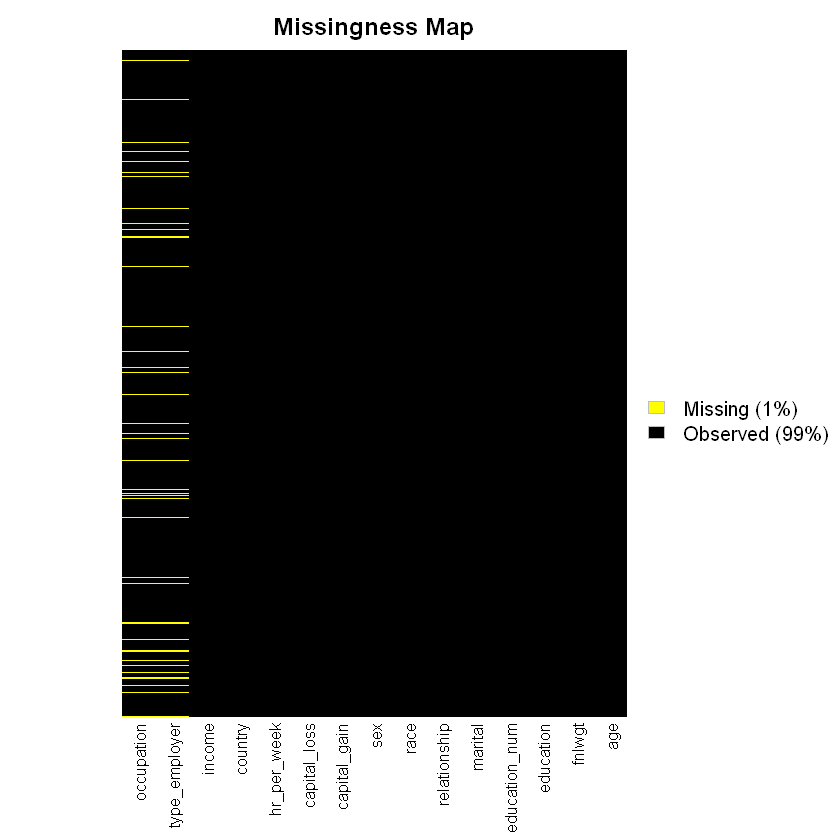

In [10]:
# use missmap to check missing values
missmap(adult, y.at = c(1), y.labels = c(""), col = c("yellow", "black"))

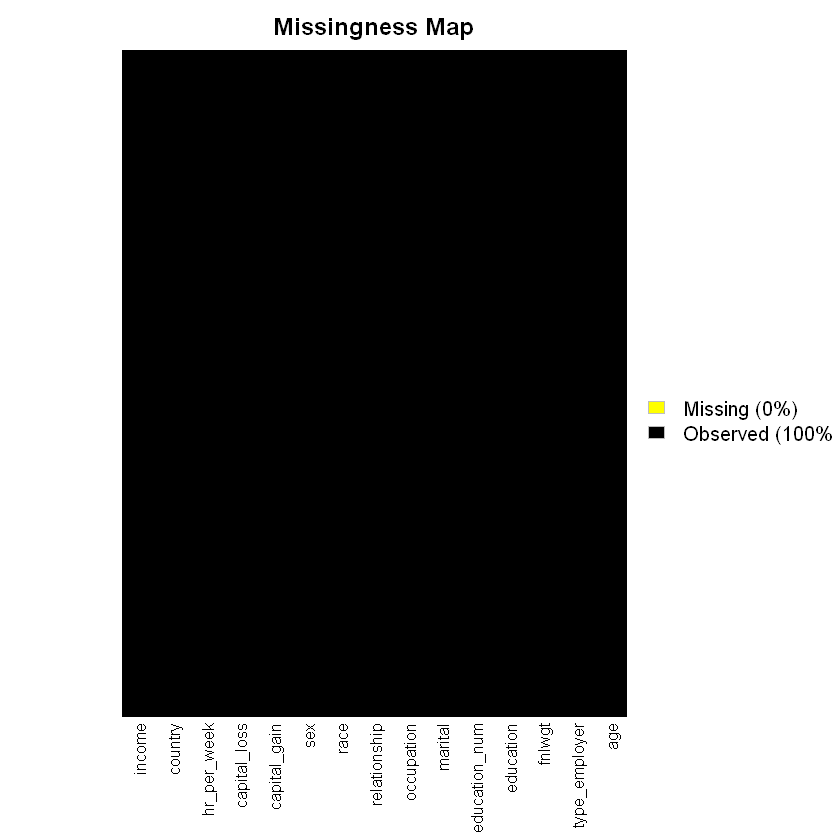

In [11]:
# Remove observations with missing values
adult <- na.omit(adult)
missmap(adult, y.at = c(1), y.labels = c(""), col = c("yellow", "black"))

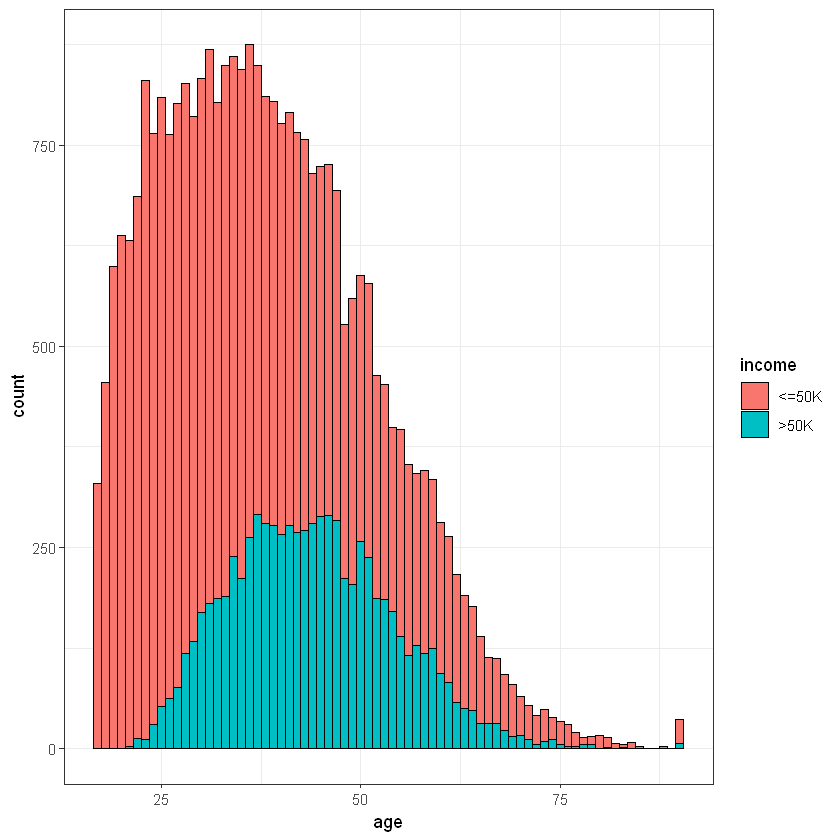

In [12]:
# Create a histogram of age, with income as the fill color
ggplot(adult, aes(age)) +
    geom_histogram(aes(fill = income), color = "black", binwidth = 1) +
    theme_bw()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


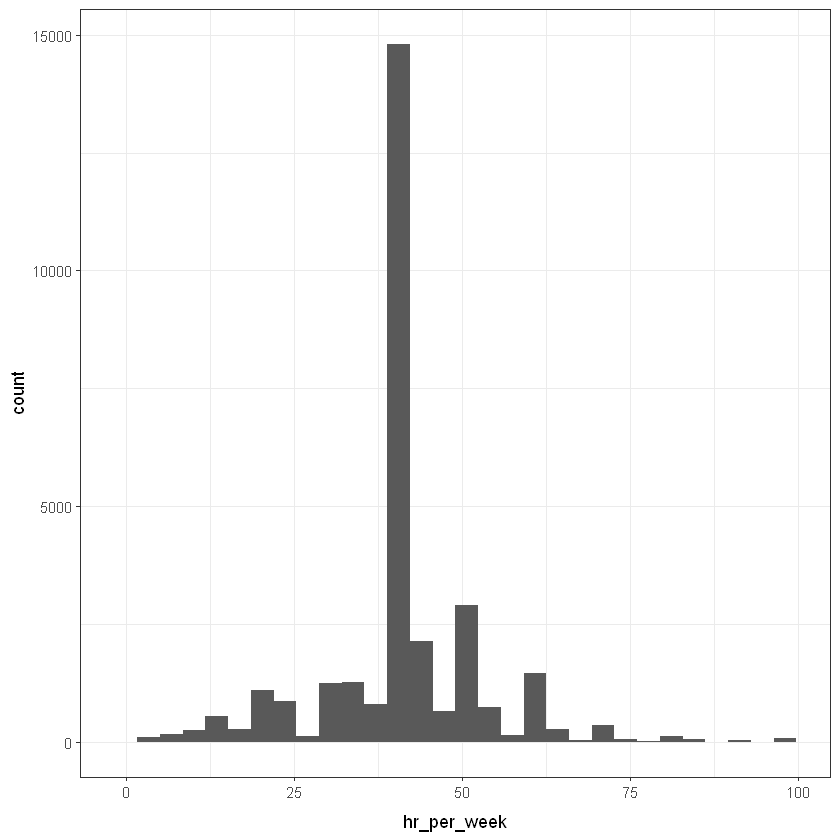

In [13]:
# Create a histogram of hours per week, with income as the fill color
ggplot(adult, aes(hr_per_week)) +
    geom_histogram() +
    theme_bw()

In [15]:
# Rename country to region
names(adult)[names(adult) == "country"] <- "region"
str(adult)

'data.frame':	30718 obs. of  15 variables:
 $ age          : int  39 50 38 53 28 37 49 52 31 42 ...
 $ type_employer: Factor w/ 6 levels "SL-gov","self-emp",..: 1 2 3 3 3 3 3 2 3 3 ...
 $ fnlwgt       : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education    : Factor w/ 16 levels "Bachelors","HS-grad",..: 1 1 2 3 1 4 5 2 4 1 ...
 $ education_num: int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital      : Factor w/ 3 levels "Never-married",..: 1 2 3 2 2 2 2 2 1 2 ...
 $ occupation   : Factor w/ 15 levels "Adm-clerical",..: 1 2 3 3 4 2 5 2 4 2 ...
 $ relationship : Factor w/ 6 levels "Not-in-family",..: 1 2 1 2 3 3 1 2 1 2 ...
 $ race         : Factor w/ 5 levels "White","Black",..: 1 1 1 2 2 1 2 1 1 1 ...
 $ sex          : Factor w/ 2 levels "Male","Female": 1 1 1 1 2 2 2 1 2 1 ...
 $ capital_gain : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital_loss : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hr_per_week  : int  40 13 40 40 40 40 16 45 50 40 ...
 $ region       :

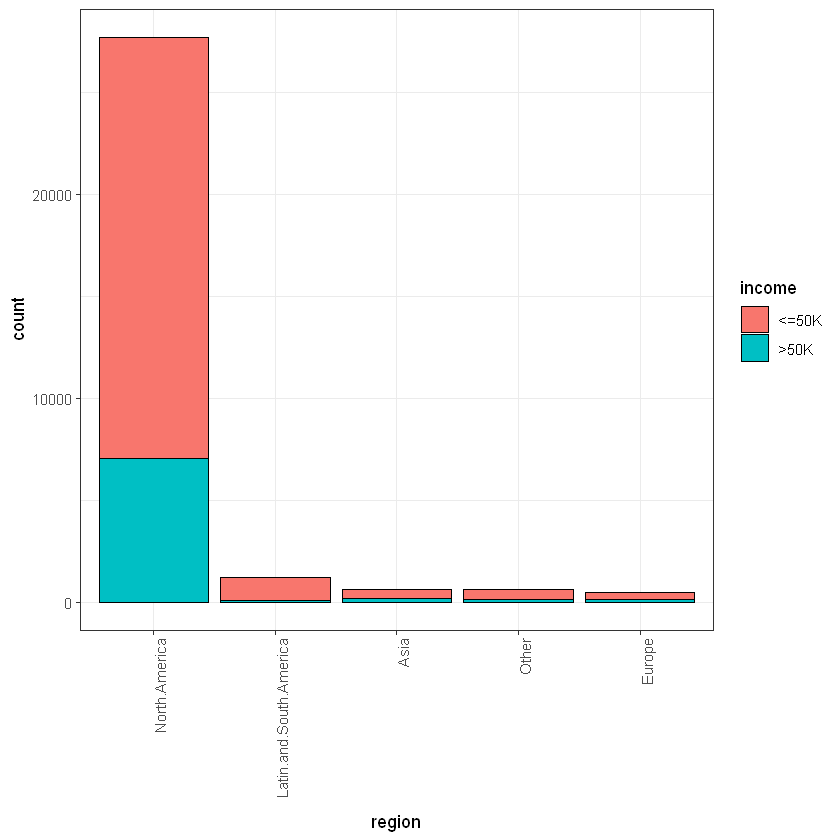

In [16]:
# Plot region vs. income
ggplot(adult, aes(region)) +
    geom_bar(aes(fill = income), color = "black") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [19]:
# Set seed
set.seed(101)

# Split data into training and testing, 70/30
sample <- sample.split(adult$income, SplitRatio = 0.70) # SplitRatio = percent of sample==TRUE

# Training Data
train <- subset(adult, sample == TRUE)

# Testing Data
test = subset(adult, sample == FALSE)

In [21]:
# train model glm() model
model = glm(income ~ ., family = binomial(logit), data = train)
summary(model)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = income ~ ., family = binomial(logit), data = train)

Coefficients: (1 not defined because of singularities)
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -4.682e+00  1.829e-01 -25.599  < 2e-16 ***
age                            2.534e-02  2.007e-03  12.627  < 2e-16 ***
type_employerself-emp          7.501e-03  8.999e-02   0.083 0.933571    
type_employerPrivate           2.371e-01  7.321e-02   3.239 0.001198 ** 
type_employerFederal-gov       6.835e-01  1.266e-01   5.399 6.71e-08 ***
type_employerUnemployed       -1.346e+01  3.688e+02  -0.036 0.970888    
fnlwgt                         5.424e-07  2.085e-07   2.601 0.009291 ** 
educationHS-grad              -1.167e+00  6.599e-02 -17.683  < 2e-16 ***
education11th                 -1.793e+00  1.876e-01  -9.561  < 2e-16 ***
educationMasters               3.441e-01  9.217e-02   3.734 0.000189 ***
education9th                  -2.015e+00  2.673e-01  -7.539 4.73e-14

In [22]:
# Use step function to create a new model
new.step.model <- step(model)

Start:  AIC=14112.05
income ~ age + type_employer + fnlwgt + education + education_num + 
    marital + occupation + relationship + race + sex + capital_gain + 
    capital_loss + hr_per_week + region



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Step:  AIC=14112.05
income ~ age + type_employer + fnlwgt + education + marital + 
    occupation + relationship + race + sex + capital_gain + capital_loss + 
    hr_per_week + region



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


                Df Deviance   AIC
<none>                14004 14112
- fnlwgt         1    14011 14117
- race           4    14019 14119
- region         4    14026 14126
- type_employer  4    14050 14150
- marital        2    14060 14164
- sex            1    14097 14203
- age            1    14165 14271
- capital_loss   1    14217 14323
- hr_per_week    1    14222 14328
- relationship   5    14288 14386
- occupation    13    14444 14526
- education     15    14718 14796
- capital_gain   1    15248 15354


In [23]:
# Summary of new model
summary(new.step.model)


Call:
glm(formula = income ~ age + type_employer + fnlwgt + education + 
    marital + occupation + relationship + race + sex + capital_gain + 
    capital_loss + hr_per_week + region, family = binomial(logit), 
    data = train)

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -4.682e+00  1.829e-01 -25.599  < 2e-16 ***
age                            2.534e-02  2.007e-03  12.627  < 2e-16 ***
type_employerself-emp          7.501e-03  8.999e-02   0.083 0.933571    
type_employerPrivate           2.371e-01  7.321e-02   3.239 0.001198 ** 
type_employerFederal-gov       6.835e-01  1.266e-01   5.399 6.71e-08 ***
type_employerUnemployed       -1.346e+01  3.688e+02  -0.036 0.970888    
fnlwgt                         5.424e-07  2.085e-07   2.601 0.009291 ** 
educationHS-grad              -1.167e+00  6.599e-02 -17.683  < 2e-16 ***
education11th                 -1.793e+00  1.876e-01  -9.561  < 2e-16 ***
educationMasters        

In [24]:
# create confusion matrix using the predict function
test$predicted.income <- predict(model, newdata = test, type = "response")

table(test$income, test$predicted.income > 0.5)

       
        FALSE TRUE
  <=50K  6372  548
  >50K    872 1423

In [25]:
# Check accuracy, recall, precision
print(paste("Accurary:", round((6372 + 1423) / (6372 + 1423 + 548 + 872), 2)))
# recall
print(paste("Recall:", round((6732 / (6372 + 548)), 2)))
# precision
print(paste("Precision:", round((6732 / (6372 + 872)), 2)))

[1] "Accurary: 0.85"
[1] "Recall: 0.97"
[1] "Precision: 0.93"
